In [1]:
from glob import glob
import re  # regular expressions
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# 1. Preliminary questions


- A. Thanks
- B. Okay
- C. In a lossless system, if the received power is less than 1, there are only two possibilities: either the optical intensity went elsewhere (scattering), or numerical errors occurred due to the discretization of the space. Scattering occurs naturally in bent waveguides, but also when discretization causes imperfect waveguide edges. In order to separate the two, one needs to estimate the discretization error by increasing resolution. The second error is inevitable for any simulation involving the solution of a differential equation. Only a computer with infinite precision and infinitely small time steps (cf. [Courant stability condition](https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition) in notebook 0) would not accumulate numerical integration errors. But for high enough resolution, meep does a good job of avoiding these kinds of error. For both of these sources a larger wavelength means a larger mode, which means that relative to a unit of wavelength, the discretization step is smaller. As a result, increasing the wavelength should have virtually the same effect as increasing the resolution, yielding better accuracy.
However, since the mode is larger for larger wavelengths, the scaterring/radiative loss is larger for a constant bending radius. So we should have two opposing effects.
- D. Modes are larger for larger wavelengths. If you consider a cross-section of a waveguide, increasing the wavelength means reducing the waveguide's dimensions by the same factor. Which means the mode would be less confined and relatively larger.
- E. Since more modal overlap increases coupling strength, it follows that larger wavelengths should result in larger coupling magnitudes.

# 2. Bent waveguide

In [2]:
csv_filenames = glob("sparams.r*um.csv")  # find all csv files with this pattern
dataset_bend = {}
for csvfile in csv_filenames:
    radius = float(re.search("\.r(.+)um", csvfile)[1])
    dataset_bend[radius] = pd.read_csv(csvfile, delimiter=',')
    print(f"Processed {csvfile}")

Processed sparams.r1.5um.csv
Processed sparams.r2.0um.csv
Processed sparams.r2.5um.csv
Processed sparams.r3.0um.csv
Processed sparams.r3.5um.csv
Processed sparams.r4.0um.csv
Processed sparams.r4.5um.csv
Processed sparams.r5.0um.csv
Processed sparams.r5.5um.csv
Processed sparams.r6.0um.csv
Processed sparams.r6.5um.csv
Processed sparams.r7.0um.csv
Processed sparams.r7.5um.csv
Processed sparams.r8.0um.csv
Processed sparams.r8.5um.csv


In [3]:
def plot_S_param(dataset, s_param, ax1, ax2):
    colors = plt.cm.viridis(np.linspace(0,1,len(dataset)))
    for idx, (param_idx, dataframe) in enumerate(sorted(dataset.items())):
        f = dataframe['f(Hz)'] / 1e12
        s = dataframe[f'real({s_param})'] + 1j * dataframe[f'imag({s_param})']
        s_mag = np.abs(s)
        s_phase = np.unwrap(np.angle(s))
        ax1.plot(f, 10*np.log10(s_mag), '.-', label=param_idx, color=colors[idx])
        ax1.set_title(s_param)
        ax1.set_xlabel(r"$f$ (THz)")
        ax1.set_ylabel("Magnitude (dB)")
#         ax1.set_ylim(-1, 0)
        ax1.grid()
        ax1.legend()
        ax2.plot(f, s_phase, '.-', label=param_idx, color=colors[idx])
        ax2.set_xlabel(r"$f$ (THz)")
        ax2.set_ylabel("Phase (rad)")
        ax2.grid()
        ax2.legend()

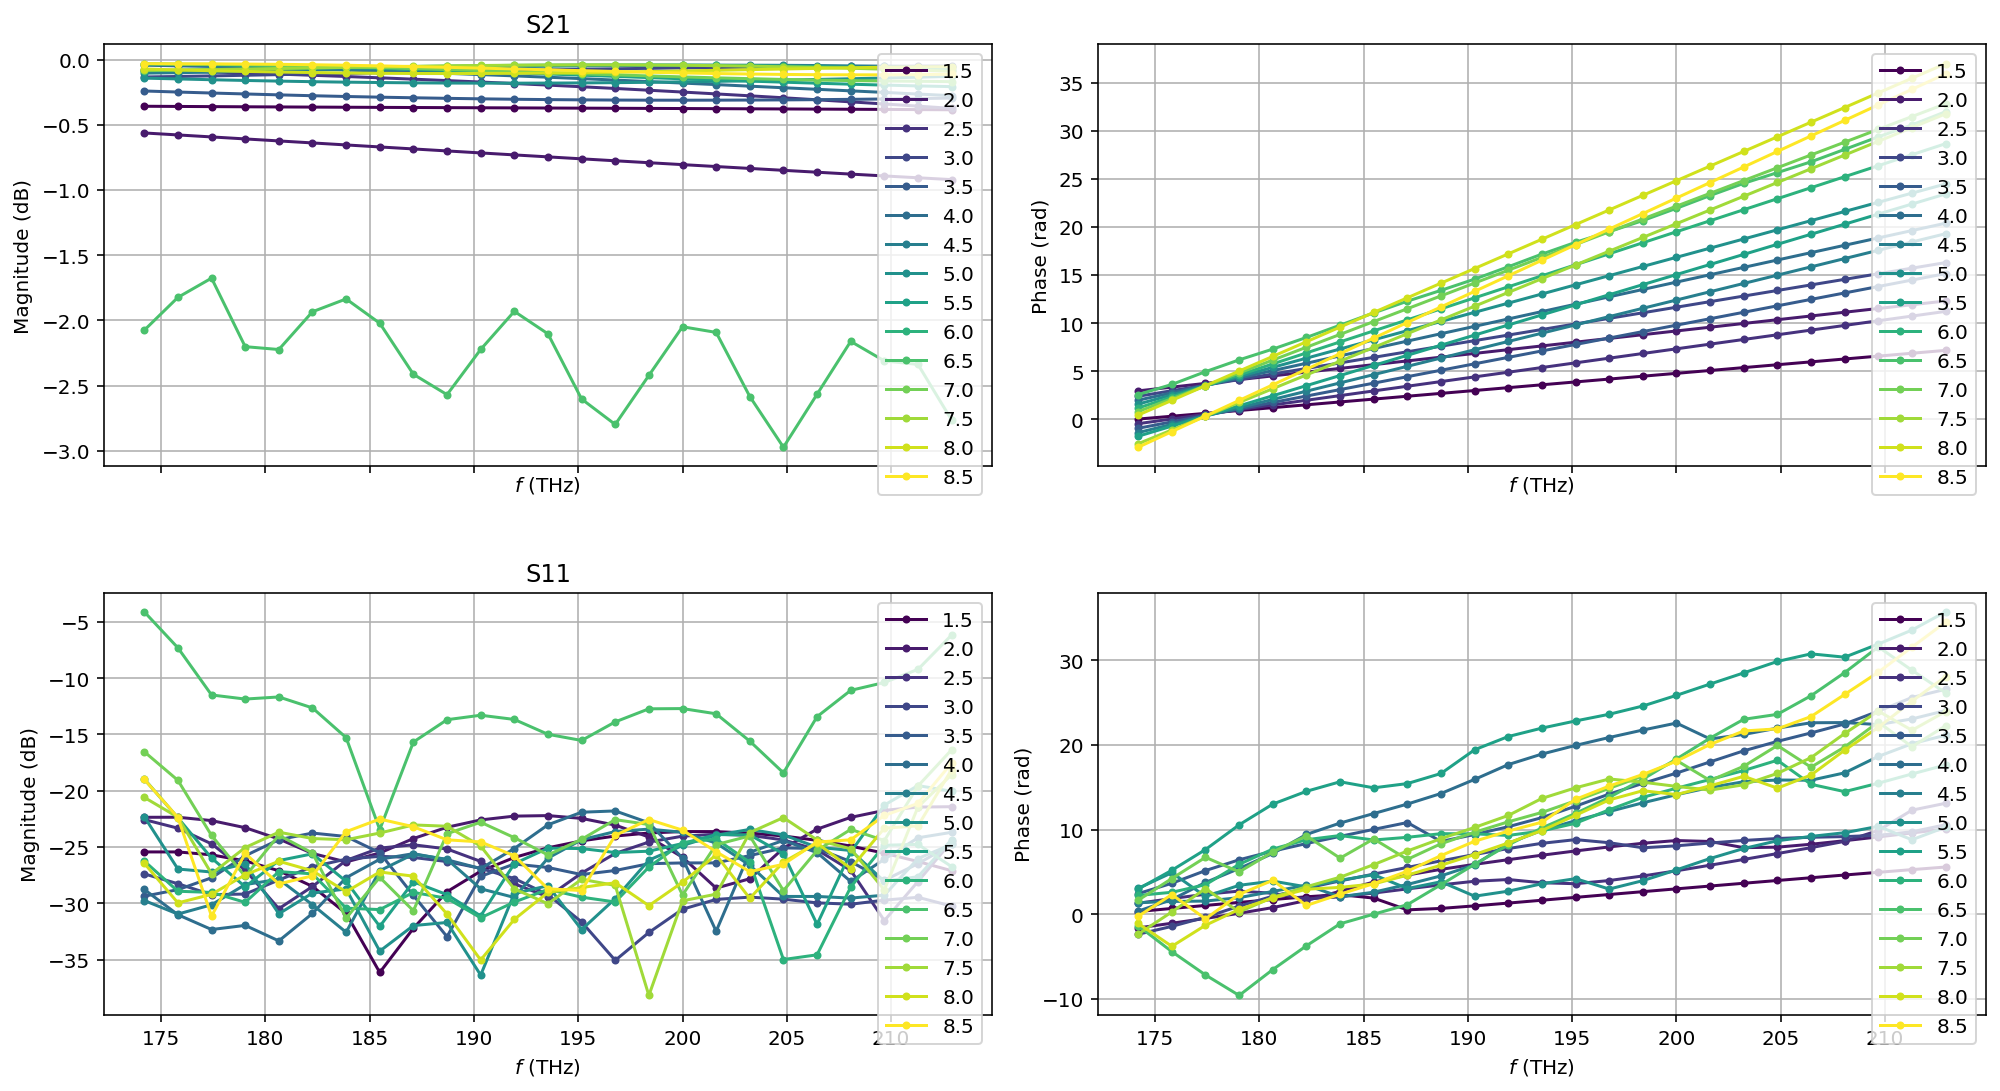

In [4]:
f, (ax) = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plot_S_param(dataset_bend, "S21", ax[0,0], ax[0,1])
plot_S_param(dataset_bend, "S11", ax[1,0], ax[1,1])
plt.tight_layout()

### A. Is the reflection significant for any radius? What explain the loss?
No. For all experiments, except for the bug in r=6.5um, all reflections remained under -20dB.

### B. What is the total size of the simulation region? How many pixels are there?
I will answer by means of an example. For a radius of 6.5um, meep says "`Computational cell is 9.8 x 9.8 x 0 with resolution 100`". That means the number of pixels is 980 x 980 = 960,040.

### C. If each pixel can host 3-dimensional E-field and H-field vectors with 64bit complex float stored in each dimension, how many megabytes of data needs to be stored at each time step? Is it feasible to save all this information throughout the FDTD simulation?
If each pixel would need to contain 3 * 64 bits of information, the total number of bits per time frame is 3 * 64 * 960,040 = 184,327,640 bits, or 23.04 megabytes. For this simulation, meep used 27,858 time steps. Therefore, the full simulated data is around 642Gb before compression. In other words, impractical to hold in memory or disk space. That is why we set monitors in advance and save fluxes instead.

### D. Bonus: Collect the simulation runtime for each radius. How does it change with different radii?
This is easy to establish if you used adroit.


radius=1.5: Elapsed run time = 54.7488 s
radius=2.0: Elapsed run time = 62.4936 s
radius=2.5: Elapsed run time = 64.3747 s
radius=3.0: Elapsed run time = 74.8898 s
radius=3.5: Elapsed run time = 109.7653 s
radius=4.0: Elapsed run time = 121.5400 s
radius=4.5: Elapsed run time = 131.5416 s
radius=5.0: Elapsed run time = 147.0559 s
radius=5.5: Elapsed run time = 173.1211 s
radius=6.0: Elapsed run time = 218.7302 s
radius=6.5: Elapsed run time = 273.7577 s
radius=7.0: Elapsed run time = 251.4028 s
radius=7.5: Elapsed run time = 217.7181 s
radius=8.0: Elapsed run time = 238.8169 s
radius=8.5: Elapsed run time = 257.2506 s


Text(0, 0.5, 'runtime(s)')

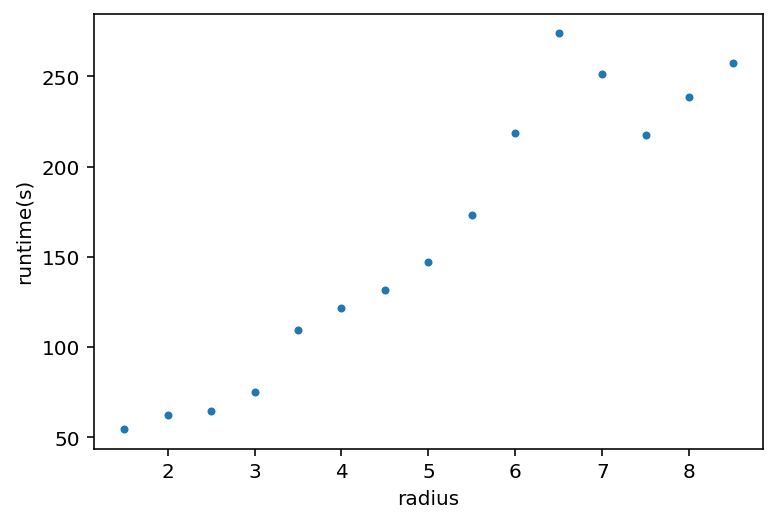

In [5]:
# Aggregating runtimes across computations
parameters = [1.5 + 0.5 * i for i in range(15)]
elapsed_time = []
for idx, radius in enumerate(parameters):
    slurm_filename = f"slurm-916905.{idx}.out"
    with open(slurm_filename) as f:
        last_line = f.readlines()[-1].rstrip()
    print(f"radius={radius}:", last_line)
    elapsed_time.append(float(re.search("= (.+) s", last_line)[1]))
    
plt.plot(parameters, elapsed_time, '.')
plt.xlabel('radius')
plt.ylabel('runtime(s)')

As we can see, it generally increases, except for the region between 6.5 and 7.5um. It might be due to how meep separates computational domains amongst 4 processors.

### Bonus: At what resolution does the accuracy of the simulation start degrading? In other words, if halving the resolution only results in a 1% relative difference in the most important target metric, it is still a good resolution.

I have found it to be around 100. Hence the default value.

## 3. Waveguide Point Coupler

### We define coupling ratio by two parameters: $\kappa$ (cross) and $t$ (bar). In this example, $S_{31}$ represents $t$ and $S_{41}$ represents $\kappa$. For a lossless coupler, the following formula should hold: $|\kappa|^2 + |t|^2 = 1$. Does it hold here? If it doesn't, where do you think the losses are coming from?

Let's view the results for S31 and S41 first.

In [6]:
csv_filenames = glob("sparams1.gap*um.csv")  # find all csv files with this pattern
dataset_coupler1 = {}
for csvfile in csv_filenames:
    gap = float(re.search("\.gap(.+)um", csvfile)[1])
    dataset_coupler1[gap] = pd.read_csv(csvfile, delimiter=',')
    print(f"Processed {csvfile}")

Processed sparams1.gap0.15um.csv
Processed sparams1.gap0.20um.csv
Processed sparams1.gap0.25um.csv
Processed sparams1.gap0.30um.csv


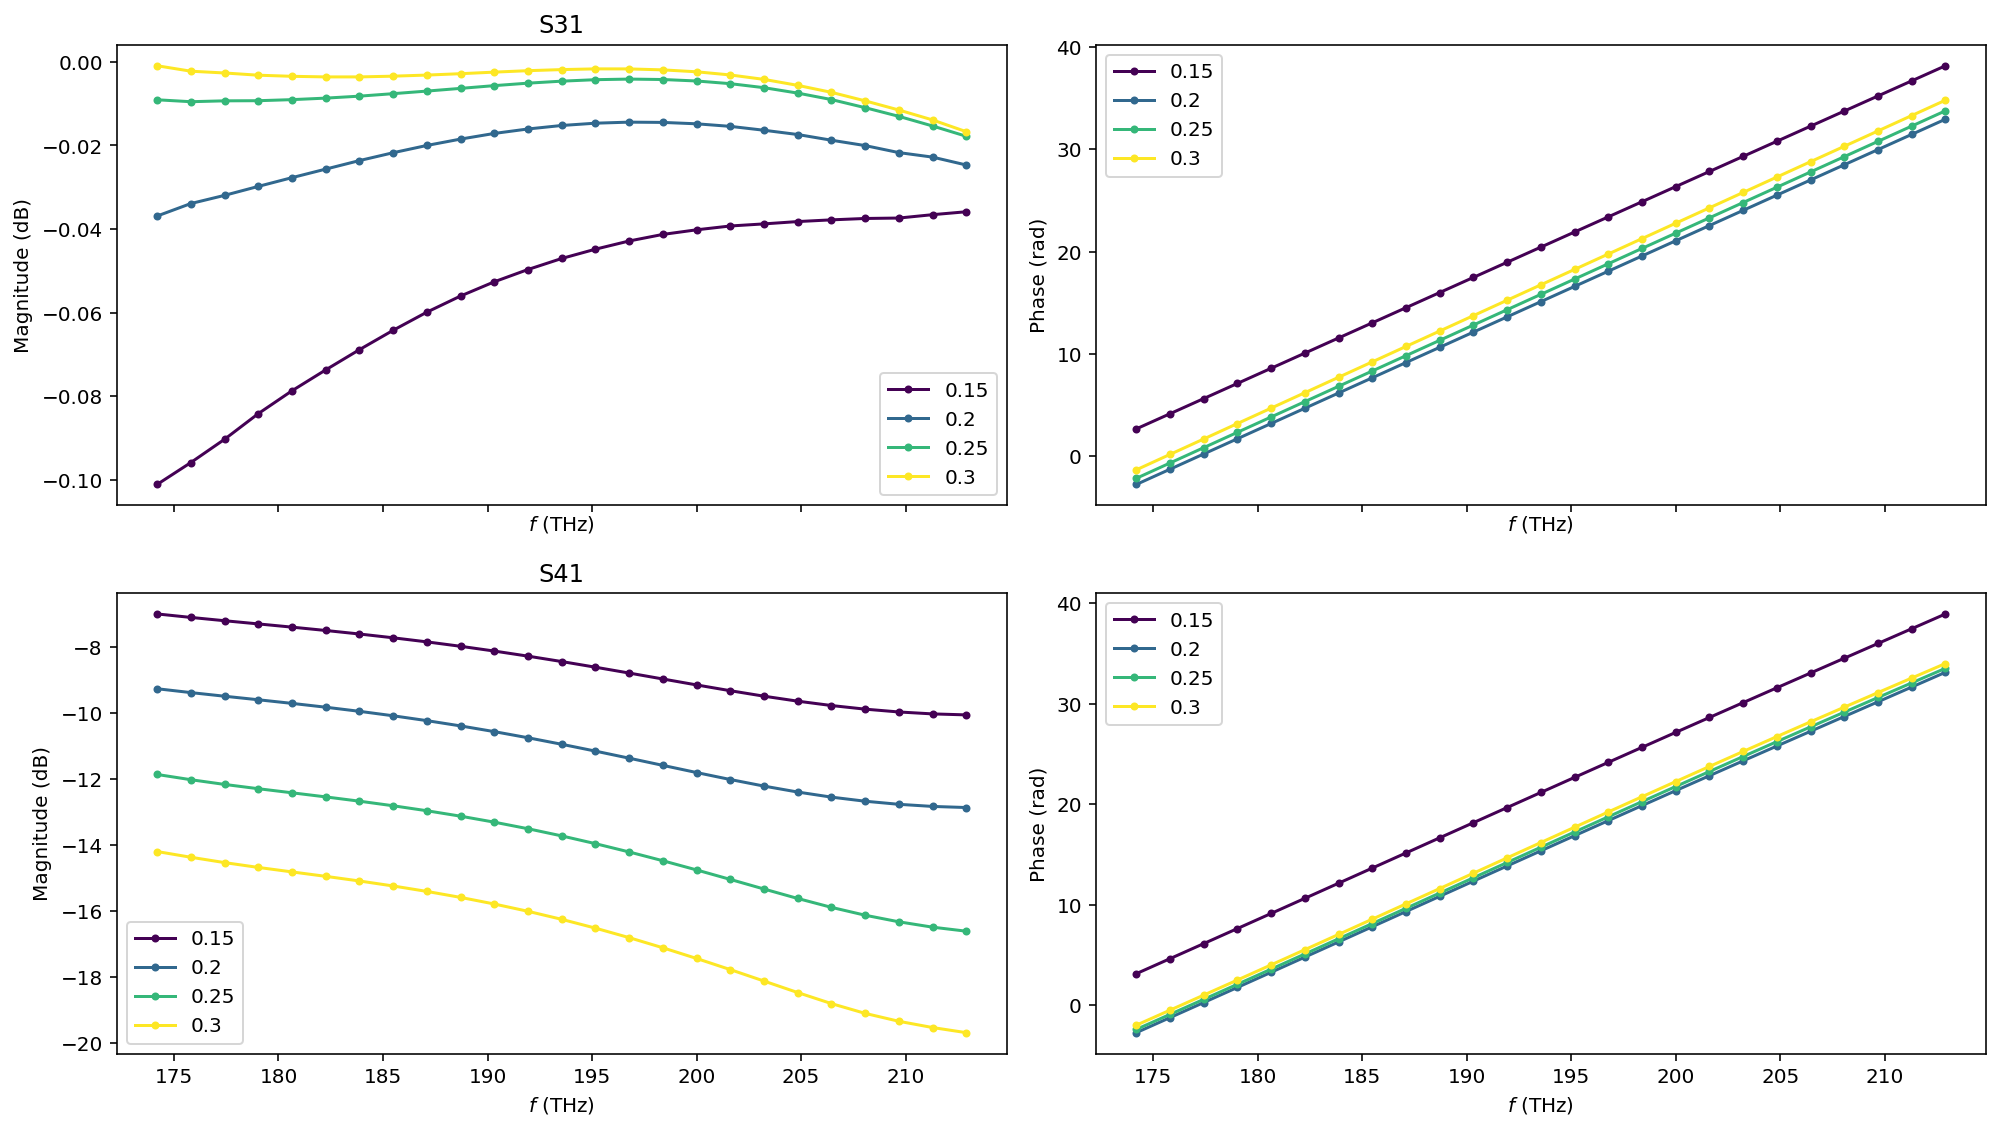

In [7]:
f, (ax) = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plot_S_param(dataset_coupler1, "S31", ax[0,0], ax[0,1])
plot_S_param(dataset_coupler1, "S41", ax[1,0], ax[1,1])
plt.tight_layout()

In [8]:
def plot_S_param_sum(dataset, s_param1, s_param2, ax1):
    colors = plt.cm.viridis(np.linspace(0,1,len(dataset)))
    for idx, (param_idx, dataframe) in enumerate(sorted(dataset.items())):
        f = dataframe['f(Hz)'] / 1e12
        s1 = dataframe[f'real({s_param1})'] + 1j * dataframe[f'imag({s_param1})']
        s2 = dataframe[f'real({s_param2})'] + 1j * dataframe[f'imag({s_param2})']
        s_mag = np.sqrt(np.abs(s1)**2 + np.abs(s2)**2)
        ax1.plot(f, 10*np.log10(s_mag), '.-', label=param_idx, color=colors[idx])
        ax1.set_title(f"$(|{s_param1}|^2+|{s_param2}|^2)^{{0.5}}$")
        ax1.set_xlabel(r"$f$ (THz)")
        ax1.set_ylabel("Magnitude (dB)")
#         ax1.set_ylim(-1, 0)
        ax1.grid()
        ax1.legend()

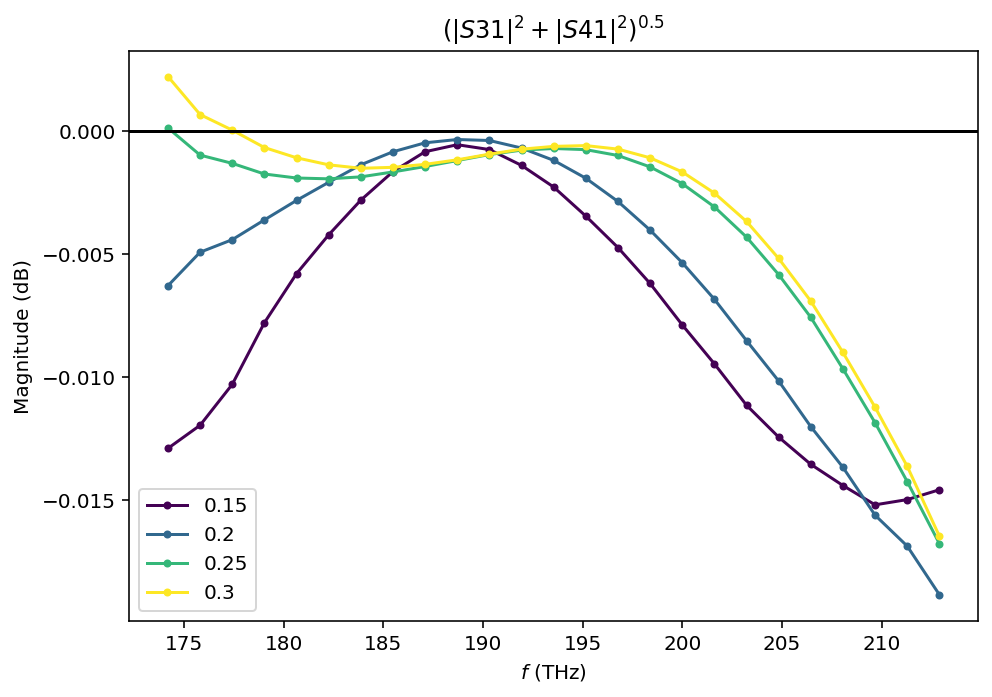

In [9]:
f, (ax) = plt.subplots(1, 1, sharex=True, figsize=(7, 5))
plot_S_param_sum(dataset_coupler1, "S31", "S41", ax)
ax.axhline(0, color='k')
plt.tight_layout()

The result is that it is very close to 1, sometimes even above 1 (the book mentioned this could happen). Short wavelengths accentuate the numerical errors, while short gaps increase errors as well. This could be explained by the increase in scaterring loss in the round waveguide.

### Even though this is not a symmetrical device in $y$, since most of the coupling happens around a single point, many people model it as a device with double mirror symmetry, like the directional coupler. This would imply that, additionally to the symmetries we explored, we would have $|S_{31}| = |S_{42}| = |t|$ and $S_{41} = S_{32} = \kappa$. Compare them and comment.

Well, let's compare.


In [10]:
csv_filenames = glob("sparams2.gap*um.csv")  # find all csv files with this pattern
dataset_coupler2 = {}
for csvfile in csv_filenames:
    gap = float(re.search("\.gap(.+)um", csvfile)[1])
    dataset_coupler2[gap] = pd.read_csv(csvfile, delimiter=',')
    print(f"Processed {csvfile}")

Processed sparams2.gap0.15um.csv
Processed sparams2.gap0.20um.csv
Processed sparams2.gap0.25um.csv
Processed sparams2.gap0.30um.csv


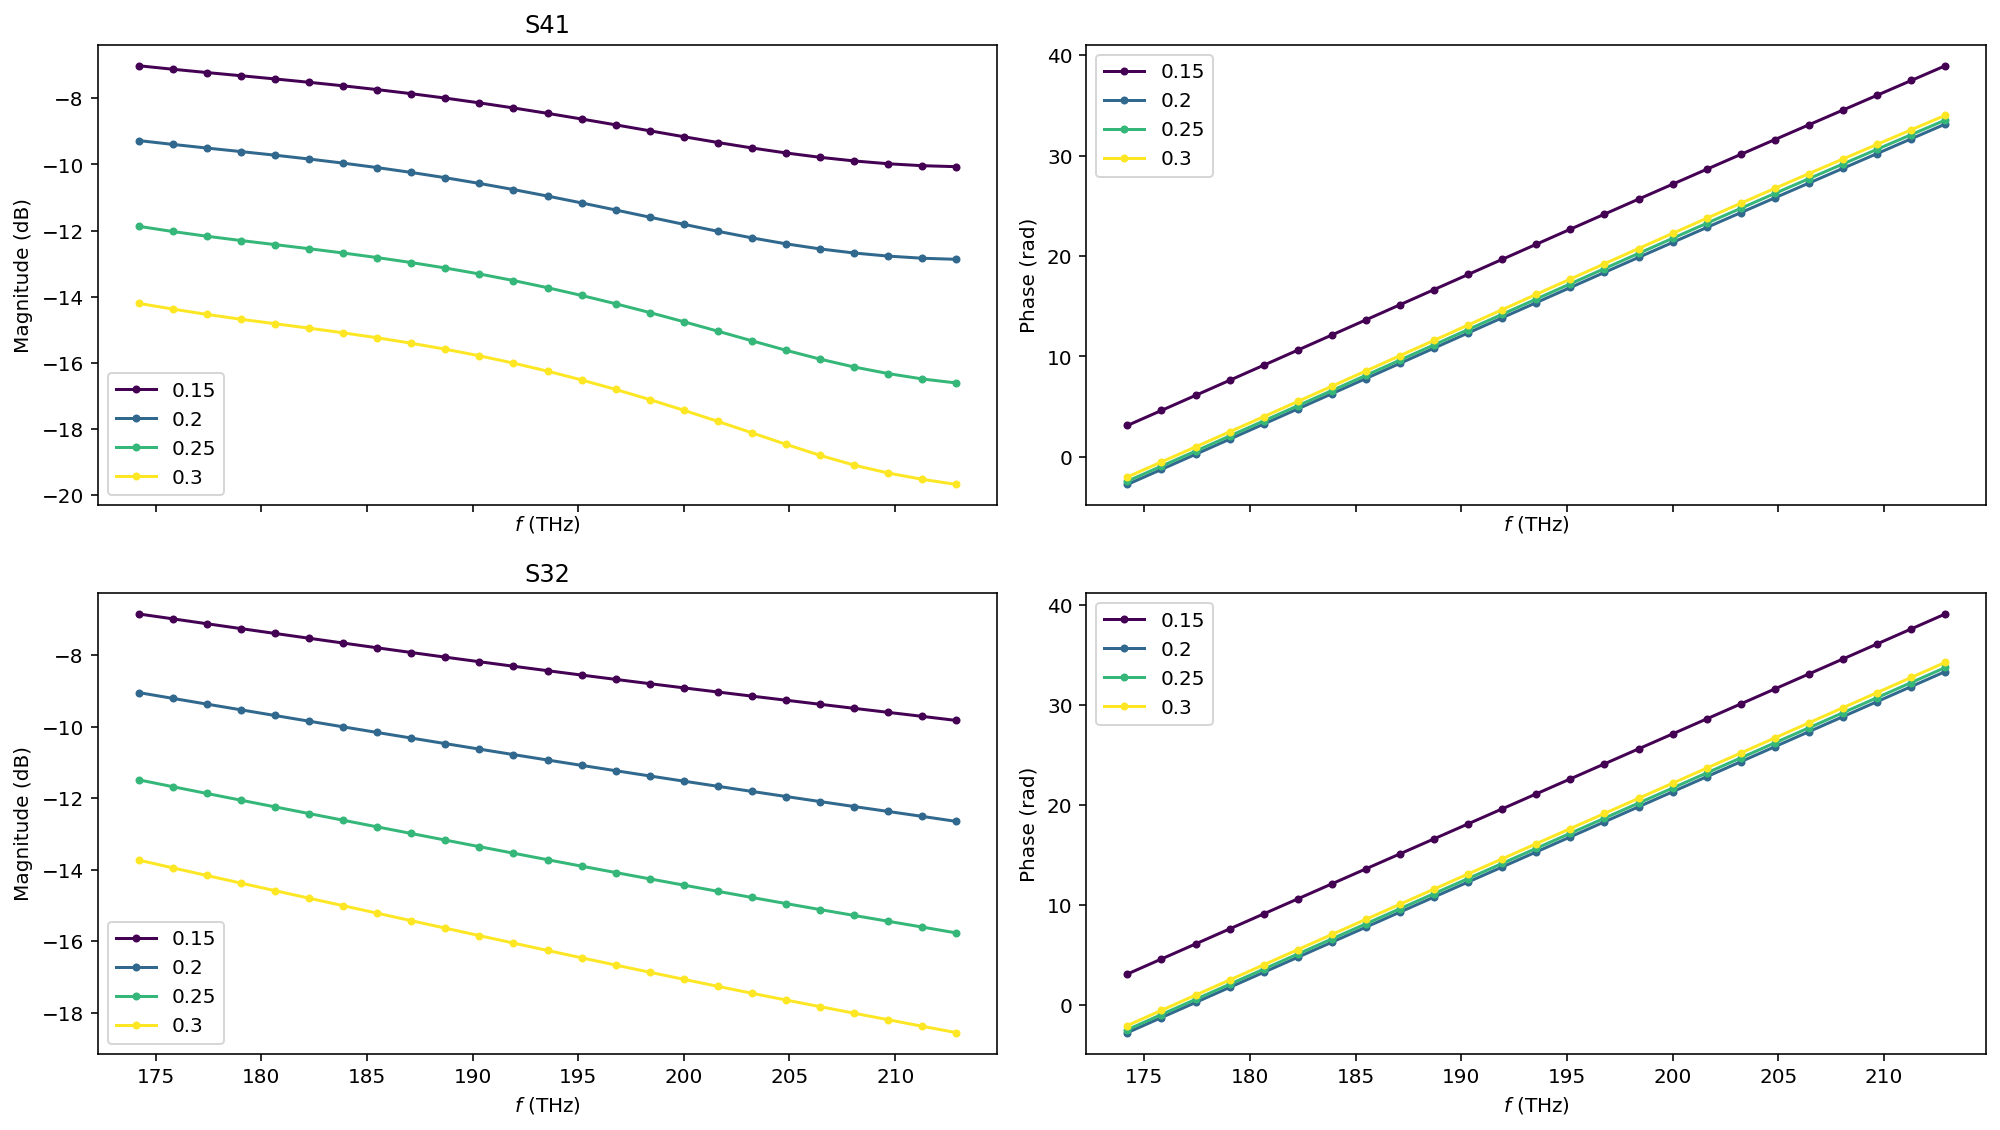

In [11]:
f, (ax) = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plot_S_param(dataset_coupler1, "S41", ax[0,0], ax[0,1])
plot_S_param(dataset_coupler2, "S32", ax[1,0], ax[1,1])
plt.tight_layout()

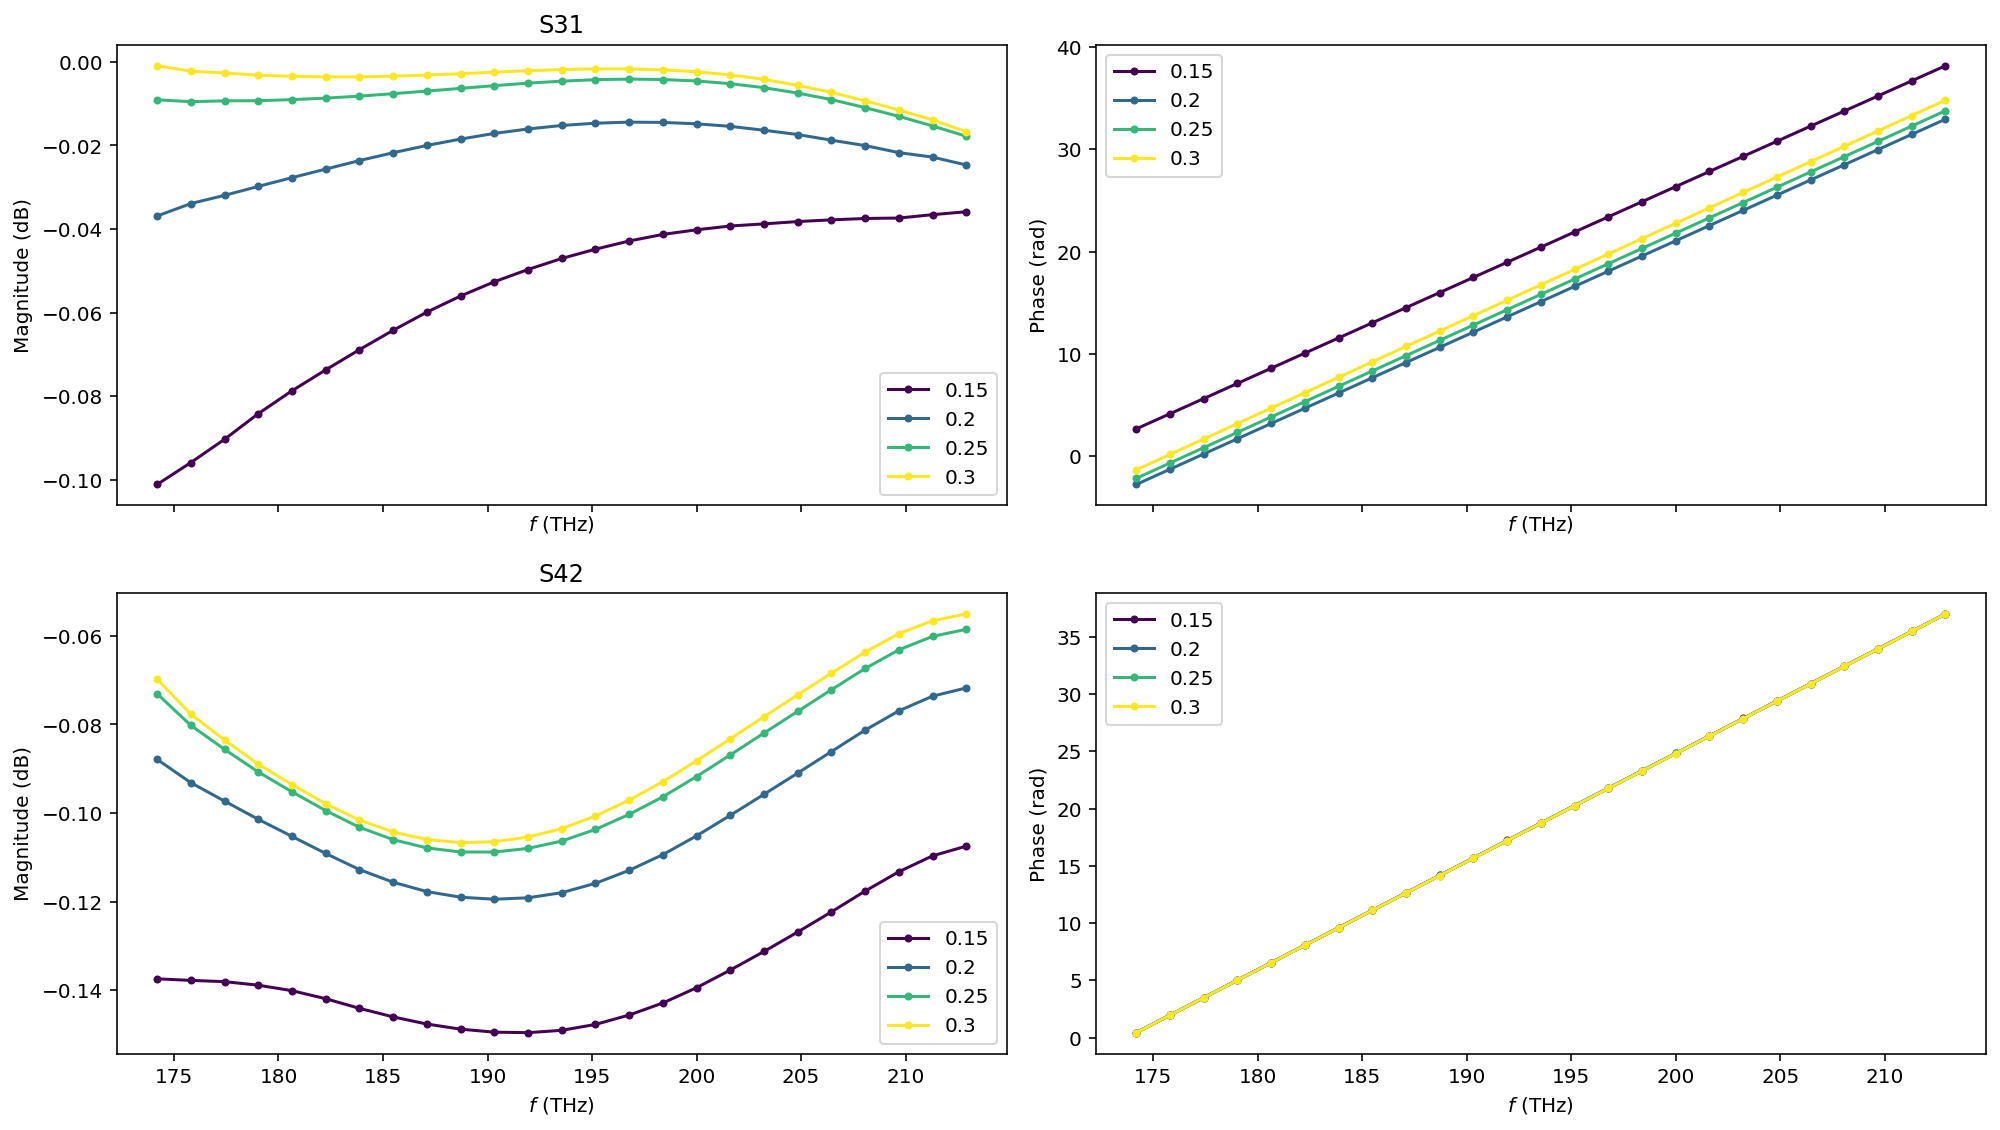

In [12]:
f, (ax) = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plot_S_param(dataset_coupler1, "S31", ax[0,0], ax[0,1])
plot_S_param(dataset_coupler2, "S42", ax[1,0], ax[1,1])
plt.tight_layout()

We can see that $S_{41} \approx  S_{32}$, but that $|S_{31}| \neq |S_{42}|$. The latter was understandable because $S_{42}$ represents travel through a curved waveguide, and $|S_{31}|$ through a straight waveguide. The agreement between $S_{41}$ and $S_{32}$ is there and it is remarkable.